# Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [2]:
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
import pattern
from pattern.en import lemma
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
import string
from wordcloud import WordCloud

In [3]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score, recall_score, precision_score,accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression

# Dataset import and understanding

In [4]:
df=pd.read_csv('C:/Users/Downloads/amazon_reviews.csv')

In [5]:
df.shape

(21000, 9)

In [6]:
df.sample(5)

,DOC_ID,LABEL,RATING,VERIFIED_PURCHASE,PRODUCT_CATEGORY,PRODUCT_ID,PRODUCT_TITLE,REVIEW_TITLE,REVIEW_TEXT
8474,8475,__label1__,5,N,Furniture,B005KUVZEA,"Altra Carson 50"" TV Stand, Espresso/Silver",Great!,Great product at a great price. The stand was ...
10938,10939,__label2__,5,Y,Home Improvement,B00314YBPM,Stop-A-Clog Drain Protectors - 2 Pack,These work well.,I have thick hair that gets in the tub/shower ...
20196,20197,__label2__,4,Y,Sports,B004CFYFDW,Cellerciser Portable Tri-Fold plus Balance Bar,Excellent,The only reason I didn't give it 5 stars is th...
18813,18814,__label2__,4,Y,Musical Instruments,B0052M1C0I,Superior C-267 Trailpak II Openback Banjo Gig Bag,"Basic bag, bargain price",This gig bag is a snug but doable fit for a Re...
17365,17366,__label2__,5,Y,Grocery,B00AG3V686,"Tim Hortons Coffee 4.33 oz each, pack of 2","Good stuff, eh?",I remember Tim Horton's coffee during my busin...


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21000 entries, 0 to 20999
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   DOC_ID             21000 non-null  int64 
 1   LABEL              21000 non-null  object
 2   RATING             21000 non-null  int64 
 3   VERIFIED_PURCHASE  21000 non-null  object
 4   PRODUCT_CATEGORY   21000 non-null  object
 5   PRODUCT_ID         21000 non-null  object
 6   PRODUCT_TITLE      21000 non-null  object
 7   REVIEW_TITLE       21000 non-null  object
 8   REVIEW_TEXT        21000 non-null  object
dtypes: int64(2), object(7)
memory usage: 1.4+ MB


In [8]:
for i in df:
    print(df[i].value_counts())

1        1
14007    1
14005    1
14004    1
14003    1
        ..
7000     1
6999     1
6998     1
6997     1
21000    1
Name: DOC_ID, Length: 21000, dtype: int64
__label1__    10500
__label2__    10500
Name: LABEL, dtype: int64
5    12210
4     3973
3     1868
1     1757
2     1192
Name: RATING, dtype: int64
Y    11698
N     9302
Name: VERIFIED_PURCHASE, dtype: int64
PC                        700
Wireless                  700
Watches                   700
Musical Instruments       700
Home Entertainment        700
Pet Products              700
Lawn and Garden           700
Apparel                   700
Video Games               700
Luggage                   700
Outdoors                  700
Shoes                     700
Home Improvement          700
Tools                     700
Video DVD                 700
Grocery                   700
Books                     700
Jewelry                   700
Home                      700
Sports                    700
Camera                    700

In [9]:
df.duplicated().sum()

0

In [10]:
df.describe()

,DOC_ID,RATING
count,21000.000000,21000.000000
mean,10500.500000,4.127952
std,6062.322162,1.278333
min,1.000000,1.000000
25%,5250.750000,4.000000
50%,10500.500000,5.000000
75%,15750.250000,5.000000
max,21000.000000,5.000000


In [11]:
df.describe(include=["object"]) 

,LABEL,VERIFIED_PURCHASE,PRODUCT_CATEGORY,PRODUCT_ID,PRODUCT_TITLE,REVIEW_TITLE,REVIEW_TEXT
count,21000,21000,21000,21000,21000,21000,21000
unique,2,2,30,18857,18865,18476,21000
top,__label1__,Y,PC,B0010O748Q,Honey Badger Garden Gloves for Digging & Plant...,Five Stars,"When least you think so, this product will sav..."
freq,10500,11698,700,4,5,83,1


In [12]:
#target variable
# label 1 as fake review
# label 2 as genuine review
df['LABEL'].value_counts()

__label1__    10500
__label2__    10500
Name: LABEL, dtype: int64

# feature engineering

In [14]:
required_columns=['RATING','VERIFIED_PURCHASE','REVIEW_TEXT','LABEL']

In [15]:
df1=df[required_columns]

In [16]:
df1.head()

,RATING,VERIFIED_PURCHASE,REVIEW_TEXT,LABEL
0,4,N,"When least you think so, this product will sav...",__label1__
1,4,Y,Lithium batteries are something new introduced...,__label1__
2,3,N,I purchased this swing for my baby. She is 6 m...,__label1__
3,4,N,I was looking for an inexpensive desk calcolat...,__label1__
4,4,N,I only use it twice a week and the results are...,__label1__


In [17]:
# convert to lowercase
df1['CLEAN_TEXT']=df1['REVIEW_TEXT'].str.lower()
df1.head()

,RATING,VERIFIED_PURCHASE,REVIEW_TEXT,LABEL,CLEAN_TEXT
0,4,N,"When least you think so, this product will sav...",__label1__,"when least you think so, this product will sav..."
1,4,Y,Lithium batteries are something new introduced...,__label1__,lithium batteries are something new introduced...
2,3,N,I purchased this swing for my baby. She is 6 m...,__label1__,i purchased this swing for my baby. she is 6 m...
3,4,N,I was looking for an inexpensive desk calcolat...,__label1__,i was looking for an inexpensive desk calcolat...
4,4,N,I only use it twice a week and the results are...,__label1__,i only use it twice a week and the results are...


In [18]:
# remove puntuation
df1['CLEAN_TEXT'] = df1['CLEAN_TEXT'].apply(lambda x: re.sub(r'[^a-zA-Z]', ' ',str(x)))

In [19]:
# Tokenization
df1['CLEAN_TEXT'] = df1['CLEAN_TEXT'].apply(lambda x: word_tokenize(x))

In [20]:
# Remove stopwords
stopwords = set(stopwords.words('english'))
df1['CLEAN_TEXT'] = df1['CLEAN_TEXT'].apply(lambda x: [word for word in x if word.lower() not in stopwords])

In [21]:
# Lemmatization
lemmatizer = WordNetLemmatizer()
df1['CLEAN_TEXT'] = df1['CLEAN_TEXT'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])

In [22]:
# Join tokens into a single string
df1['CLEAN_TEXT'] = df1['CLEAN_TEXT'].apply(lambda x: ' '.join(x))

In [23]:
df1.head(10)

,RATING,VERIFIED_PURCHASE,REVIEW_TEXT,LABEL,CLEAN_TEXT
0,4,N,"When least you think so, this product will sav...",__label1__,least think product save day keep around case ...
1,4,Y,Lithium batteries are something new introduced...,__label1__,lithium battery something new introduced marke...
2,3,N,I purchased this swing for my baby. She is 6 m...,__label1__,purchased swing baby month pretty much grown l...
3,4,N,I was looking for an inexpensive desk calcolat...,__label1__,looking inexpensive desk calcolatur work every...
4,4,N,I only use it twice a week and the results are...,__label1__,use twice week result great used teeth whiteni...
5,3,N,I'm not sure what this is supposed to be but I...,__label1__,sure supposed would recommend little research ...
6,4,N,Pleased with ping pong table. 11 year old and ...,__label1__,pleased ping pong table year old year old blas...
7,4,Y,Great vitamin C serum... I really like the oil...,__label1__,great vitamin c serum really like oil feeling ...
8,4,N,I've used tide pods laundry detergent for many...,__label1__,used tide pod laundry detergent many year grea...
9,1,N,Everybody wants to fall for their promises. Bu...,__label1__,everybody want fall promise relatively unheard...


In [24]:
# label encoding
df1['LABEL']=df1['LABEL'].map({'__label1__':0,'__label2__':1})
df1['VERIFIED_PURCHASE']=df1['VERIFIED_PURCHASE'].map({'N':0,'Y':1})
df1.head()

,RATING,VERIFIED_PURCHASE,REVIEW_TEXT,LABEL,CLEAN_TEXT
0,4,0,"When least you think so, this product will sav...",0,least think product save day keep around case ...
1,4,1,Lithium batteries are something new introduced...,0,lithium battery something new introduced marke...
2,3,0,I purchased this swing for my baby. She is 6 m...,0,purchased swing baby month pretty much grown l...
3,4,0,I was looking for an inexpensive desk calcolat...,0,looking inexpensive desk calcolatur work every...
4,4,0,I only use it twice a week and the results are...,0,use twice week result great used teeth whiteni...


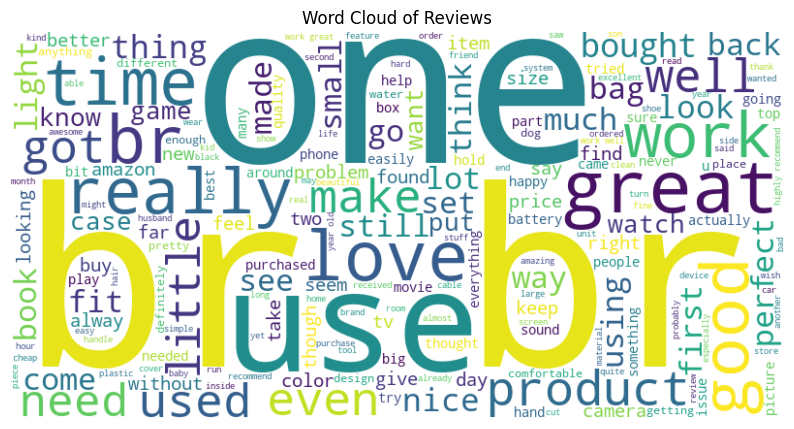

In [25]:
# Sample text data
reviews = df1['CLEAN_TEXT']
text_data = ' '.join(reviews)

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text_data)

# Create a plot
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud of Reviews")

# Display the plot
plt.show()

In [26]:
# Here we see that a br word comes everytime with is not a appropriate word.
# words such as one,use,love,time,great,really,good are positive words which shows that how 
# fake user comment good about each and every product

In [27]:
# part 1 Comparing CountVectorization and TF-IDF
# part 2 Comparing using verified purchase and without verified purchased

# CountVectorization

In [28]:
# Extract relevant feature columns
feature_columns = ['RATING','VERIFIED_PURCHASE']
text_column = 'CLEAN_TEXT'

In [29]:
# Convert categorical features to numerical using LabelEncoder
label_encoder = LabelEncoder()
for column in feature_columns:
    df[column] = label_encoder.fit_transform(df[column])

In [30]:
# Calculate review length
df1['REVIEW_LENGTH'] = df1[text_column].apply(len)

In [31]:
# Extract text data using CountVectorizer or Tf-idf
vectorizer = CountVectorizer(max_features=1400)
text_data = vectorizer.fit_transform(df1[text_column])

In [32]:
# Create feature vector combining review content, rating, verified purchase, and review length
feature_vector = pd.concat([pd.DataFrame(text_data.toarray()), df1[feature_columns], df1['REVIEW_LENGTH']], axis=1)

In [33]:
feature_vector.head()

,0,1,2,3,4,5,6,7,8,9,...,1393,1394,1395,1396,1397,1398,1399,RATING,VERIFIED_PURCHASE,REVIEW_LENGTH
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,4,0,60
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,4,1,278
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,3,0,118
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,4,0,118
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,4,0,172


In [34]:
feature_vector.shape

(21000, 1403)

In [35]:
# Split the data into training and testing sets
X = feature_vector.values
y = df1['LABEL'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [36]:
# Scale the data using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [37]:
# Define parameter grid for grid search
param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['newton-cg']
}

In [38]:
# Initialize the logistic regression model
logreg = LogisticRegression()

In [39]:
# Perform grid search with cross-validation
grid_search = GridSearchCV(logreg, param_grid, cv=5)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [0.01, 0.1, 1, 10], 'penalty': ['l1', 'l2'],
                         'solver': ['newton-cg']})

In [40]:
# Print best parameters and best score
print("Best Parameters: ", grid_search.best_params_)
print("Best Score: ", grid_search.best_score_)

Best Parameters:  {'C': 1, 'penalty': 'l2', 'solver': 'newton-cg'}
Best Score:  0.8072619047619047


In [41]:
# Make predictions on the testing data using the best estimator
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
y_pred_train= best_model.predict(X_train)

In [42]:
# Calculate the accuracy of the model
accuracy = accuracy_score(y_train, y_pred_train)
print("Accuracy for train data:", accuracy)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy for test data:", accuracy)

Accuracy for train data: 0.8300595238095239
Accuracy for test data: 0.7966666666666666


In [43]:
# compute recall, and precision
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)

print('Recall: {:.4f}'.format(recall))
print('Precision: {:.4f}'.format(precision))

Recall: 0.8508
Precision: 0.7656


# TF_IDF Vectorization

In [44]:
# Extract relevant feature columns
feature_columns = ['RATING','VERIFIED_PURCHASE']
text_column = 'CLEAN_TEXT'

In [45]:
# Convert categorical features to numerical using LabelEncoder
label_encoder = LabelEncoder()
for column in feature_columns:
    df[column] = label_encoder.fit_transform(df[column])

In [46]:
# Calculate review length
df1['REVIEW_LENGTH'] = df1[text_column].apply(len)

In [47]:
# Extract text data using Tf-idf
vectorizer = TfidfVectorizer(max_features=1400)
text_data = vectorizer.fit_transform(df1[text_column])

In [48]:
# Create feature vector combining review content, rating, verified purchase, and review length
feature_vector = pd.concat([pd.DataFrame(text_data.toarray()), df1[feature_columns], df1['REVIEW_LENGTH']], axis=1)

In [49]:
feature_vector.head()

,0,1,2,3,4,5,6,7,8,9,...,1393,1394,1395,1396,1397,1398,1399,RATING,VERIFIED_PURCHASE,REVIEW_LENGTH
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,0,60
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,1,278
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,0,118
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,0,118
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,0,172


In [50]:
feature_vector.shape

(21000, 1403)

In [51]:
# Split the data into training and testing sets
X = feature_vector.values
y = df1['LABEL'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [52]:
# Scale the data using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [53]:
# Define parameter grid for grid search
param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['newton-cg']
}

In [54]:
# Initialize the logistic regression model
logreg = LogisticRegression()

In [55]:
# Perform grid search with cross-validation
grid_search = GridSearchCV(logreg, param_grid, cv=5)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [0.01, 0.1, 1, 10], 'penalty': ['l1', 'l2'],
                         'solver': ['newton-cg']})

In [56]:
# Print best parameters and best score
print("Best Parameters: ", grid_search.best_params_)
print("Best Score: ", grid_search.best_score_)

Best Parameters:  {'C': 1, 'penalty': 'l2', 'solver': 'newton-cg'}
Best Score:  0.8001190476190476


In [57]:
# Make predictions on the testing data using the best estimator
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
y_pred_train= best_model.predict(X_train)

In [58]:
# Calculate the accuracy of the model
accuracy = accuracy_score(y_train, y_pred_train)
print("Accuracy:", accuracy)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.8283928571428572
Accuracy: 0.789047619047619


In [59]:
# compute recall, and precision
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)

print('Recall: {:.4f}'.format(recall))
print('Precision: {:.4f}'.format(precision))

Recall: 0.8096
Precision: 0.7754


# using CountVectorization without Verified Purchased column

In [60]:
# Extract relevant feature columns
feature_columns = ['RATING']
text_column = 'CLEAN_TEXT'

In [61]:
# Convert categorical features to numerical using LabelEncoder
label_encoder = LabelEncoder()
for column in feature_columns:
    df[column] = label_encoder.fit_transform(df[column])

In [62]:
# Calculate review length
df1['REVIEW_LENGTH'] = df1[text_column].apply(len)

In [63]:
# Extract text data using CountVectorizer or Tf-idf
vectorizer = CountVectorizer(max_features=1400)
text_data = vectorizer.fit_transform(df1[text_column])

In [64]:
# Create feature vector combining review content, rating, verified purchase, and review length
feature_vector = pd.concat([pd.DataFrame(text_data.toarray()), df1[feature_columns], df1['REVIEW_LENGTH']], axis=1)

In [65]:
feature_vector.head()

,0,1,2,3,4,5,6,7,8,9,...,1392,1393,1394,1395,1396,1397,1398,1399,RATING,REVIEW_LENGTH
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,4,60
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,4,278
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,3,118
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,4,118
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,4,172


In [66]:
feature_vector.shape

(21000, 1402)

In [67]:
# Split the data into training and testing sets
X = feature_vector.values
y = df1['LABEL'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [68]:
# Scale the data using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [69]:
# Define parameter grid for grid search
param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['newton-cg']
}

In [70]:
# Initialize the logistic regression model
logreg = LogisticRegression()

In [71]:
# Perform grid search with cross-validation
grid_search = GridSearchCV(logreg, param_grid, cv=5)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [0.01, 0.1, 1, 10], 'penalty': ['l1', 'l2'],
                         'solver': ['newton-cg']})

In [72]:
# Print best parameters and best score
print("Best Parameters: ", grid_search.best_params_)
print("Best Score: ", grid_search.best_score_)

Best Parameters:  {'C': 1, 'penalty': 'l2', 'solver': 'newton-cg'}
Best Score:  0.6272023809523809


In [73]:
# Make predictions on the testing data using the best estimator
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
y_pred_train= best_model.predict(X_train)

In [74]:
# Calculate the accuracy of the model
accuracy = accuracy_score(y_train, y_pred_train)
print("Accuracy for train data:", accuracy)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy for test data:", accuracy)

Accuracy for train data: 0.6860119047619048
Accuracy for test data: 0.6428571428571429


In [75]:
# compute recall, and precision
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)

print('Recall: {:.4f}'.format(recall))
print('Precision: {:.4f}'.format(precision))

Recall: 0.6273
Precision: 0.6440


# Graphical Representation

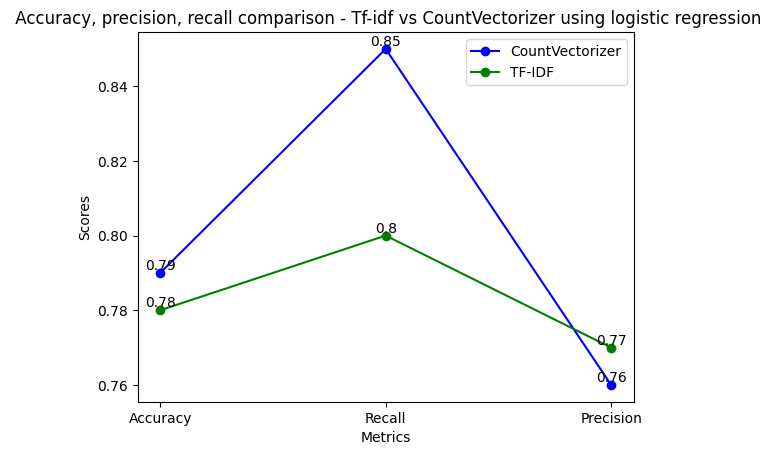

In [82]:
# Data for Model 1
model1_labels = ['Accuracy', 'Recall', 'Precision']
model1_scores = [0.79, 0.85, 0.76]

# Data for Model 2
model2_labels = ['Accuracy', 'Recall', 'Precision']
model2_scores = [0.78, 0.80, 0.77]

# Create a new plot
plt.figure()

#define title
plt.title(" Accuracy, precision, recall comparison - Tf-idf vs CountVectorizer using logistic regression")

# Define the axes
plt.xlabel("Metrics")
plt.ylabel("Scores")

# Define the x-axis positions
x = range(len(model1_labels))

# Plot Model 1
plt.plot(x, model1_scores, 'o-', label="CountVectorizer",color='blue')

# Plot Model 2
plt.plot(x, model2_scores, 'o-', label="TF-IDF",color='green')

# Add scores as labels
for i, score in enumerate(model1_scores):
    plt.text(i, score, str(score), ha='center', va='bottom')

for i, score in enumerate(model2_scores):
    plt.text(i, score, str(score), ha='center', va='bottom')

# Set x-axis labels
plt.xticks(x, model1_labels)

# Add a legend
plt.legend()

# Display the graph
plt.show()


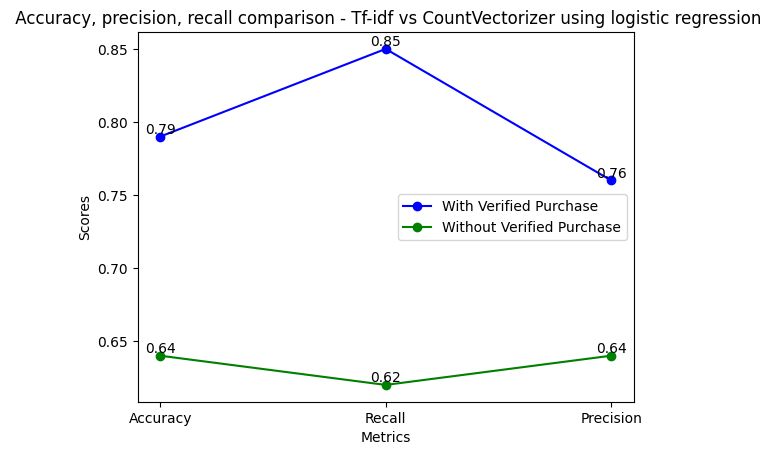

In [83]:
# Data for Model 1
model1_labels = ['Accuracy', 'Recall', 'Precision']
model1_scores = [0.79, 0.85, 0.76]

# Data for Model 2
model2_labels = ['Accuracy', 'Recall', 'Precision']
model2_scores = [0.64, 0.62, 0.64]

# Create a new plot
plt.figure()

#define title
plt.title(" Accuracy, precision, recall comparison - Tf-idf vs CountVectorizer using logistic regression")

# Define the axes
plt.xlabel("Metrics")
plt.ylabel("Scores")

# Define the x-axis positions
x = range(len(model1_labels))

# Plot Model 1
plt.plot(x, model1_scores, 'o-', label="With Verified Purchase",color='blue')

# Plot Model 2
plt.plot(x, model2_scores, 'o-', label="Without Verified Purchase",color='green')

# Add scores as labels
for i, score in enumerate(model1_scores):
    plt.text(i, score, str(score), ha='center', va='bottom')

for i, score in enumerate(model2_scores):
    plt.text(i, score, str(score), ha='center', va='bottom')

# Set x-axis labels
plt.xticks(x, model1_labels)

# Add a legend
plt.legend()

# Display the graph
plt.show()
